In [10]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

class NaturalGasStorageValuation:
    """
    A prototype pricing model for natural gas storage contracts.
    Values contracts based on injection/withdrawal schedules, storage costs, and market prices.
    """
    
    def __init__(self, price_data):
        """
        Initialize with price data from our forecasting model
        
        Args:
            price_data: DataFrame with 'date' and 'price' columns
        """
        self.price_data = price_data.set_index('date')['price']
    
    def calculate_contract_value(self, 
                               injection_dates,
                               withdrawal_dates, 
                               injection_volumes,
                               withdrawal_volumes,
                               injection_rate,
                               withdrawal_rate, 
                               max_storage_capacity,
                               storage_cost_per_day,
                               injection_fee_per_mmbtu,
                               withdrawal_fee_per_mmbtu,
                               transport_cost_per_trip):
        """
        Calculate the net present value of a natural gas storage contract.
        
        Args:
            injection_dates: List of dates when gas is injected
            withdrawal_dates: List of dates when gas is withdrawn  
            injection_volumes: List of volumes injected (MMBtu)
            withdrawal_volumes: List of volumes withdrawn (MMBtu)
            injection_rate: Maximum injection rate (MMBtu/day)
            withdrawal_rate: Maximum withdrawal rate (MMBtu/day)
            max_storage_capacity: Maximum storage volume (MMBtu)
            storage_cost_per_day: Daily storage rental cost ($)
            injection_fee_per_mmbtu: Fee for injection ($/MMBtu)
            withdrawal_fee_per_mmbtu: Fee for withdrawal ($/MMBtu)
            transport_cost_per_trip: Cost to transport gas to/from facility ($)
            
        Returns:
            Dictionary with contract valuation details
        """
        
        try:
            # Validate inputs
            self._validate_inputs(injection_dates, withdrawal_dates, injection_volumes, withdrawal_volumes)
            
            # Sort all operations chronologically
            operations = self._create_operations_timeline(injection_dates, withdrawal_dates, 
                                                        injection_volumes, withdrawal_volumes)
            
            # Calculate cash flows
            cash_flows = self._calculate_cash_flows(operations, injection_rate, withdrawal_rate,
                                                  max_storage_capacity, storage_cost_per_day,
                                                  injection_fee_per_mmbtu, withdrawal_fee_per_mmbtu,
                                                  transport_cost_per_trip)
            
            # Calculate summary statistics
            summary = self._calculate_summary_statistics(cash_flows)
            
            return {
                'net_present_value': summary['npv'],
                'total_revenue': summary['total_revenue'],
                'total_costs': summary['total_costs'],
                'storage_costs': summary['storage_costs'],
                'injection_costs': summary['injection_costs'],
                'withdrawal_costs': summary['withdrawal_costs'],
                'transport_costs': summary['transport_costs'],
                'cash_flow_details': cash_flows,
                'operations_summary': self._summarize_operations(operations),
                'success': True
            }
            
        except Exception as e:
            return {
                'success': False,
                'error': str(e),
                'net_present_value': 0,
                'total_revenue': 0,
                'total_costs': 0,
                'storage_costs': 0,
                'injection_costs': 0,
                'withdrawal_costs': 0,
                'transport_costs': 0
            }
    
    def _validate_inputs(self, injection_dates, withdrawal_dates, injection_volumes, withdrawal_volumes):
        """Validate input parameters"""
        if len(injection_dates) != len(injection_volumes):
            raise ValueError("Number of injection dates must match number of injection volumes")
        if len(withdrawal_dates) != len(withdrawal_volumes):
            raise ValueError("Number of withdrawal dates must match number of withdrawal volumes")
        if sum(injection_volumes) != sum(withdrawal_volumes):
            raise ValueError("Total injection volume must equal total withdrawal volume")
    
    def _create_operations_timeline(self, injection_dates, withdrawal_dates, injection_volumes, withdrawal_volumes):
        """Create a chronological timeline of all operations"""
        operations = []
        
        # Add injection operations
        for date, volume in zip(injection_dates, injection_volumes):
            operations.append({
                'date': date,
                'type': 'injection',
                'volume': volume,
                'price': self._get_price(date)
            })
        
        # Add withdrawal operations  
        for date, volume in zip(withdrawal_dates, withdrawal_volumes):
            operations.append({
                'date': date,
                'type': 'withdrawal', 
                'volume': volume,
                'price': self._get_price(date)
            })
        
        # Sort by date
        operations.sort(key=lambda x: x['date'])
        return operations
    
    def _get_price(self, date):
        """Get price for a given date using our forecasting model"""
        try:
            # Convert to datetime if string
            if isinstance(date, str):
                date = datetime.strptime(date, '%Y-%m-%d')
            
            # For exact date matches
            if date in self.price_data.index:
                return self.price_data[date]
            
            # For dates between our data points, interpolate
            # Find nearest dates in our data
            earlier_dates = self.price_data.index[self.price_data.index <= date]
            later_dates = self.price_data.index[self.price_data.index >= date]
            
            if len(earlier_dates) == 0 or len(later_dates) == 0:
                # Extrapolate using trend (simplified)
                return self.price_data.iloc[-1] if date > self.price_data.index.max() else self.price_data.iloc[0]
            
            prev_date = earlier_dates.max()
            next_date = later_dates.min()
            
            if prev_date == next_date:
                return self.price_data[prev_date]
            
            # Linear interpolation
            days_between = (next_date - prev_date).days
            days_to_target = (date - prev_date).days
            weight = days_to_target / days_between
            
            interpolated_price = (self.price_data[prev_date] * (1 - weight) + 
                                 self.price_data[next_date] * weight)
            return max(0, interpolated_price)  # Ensure non-negative price
                    
        except Exception as e:
            print(f"Price lookup error for {date}: {e}")
            return 10.0  # Default fallback price
    
    def _calculate_cash_flows(self, operations, injection_rate, withdrawal_rate,
                            max_storage_capacity, storage_cost_per_day,
                            injection_fee_per_mmbtu, withdrawal_fee_per_mmbtu,
                            transport_cost_per_trip):
        """Calculate detailed cash flows for all operations"""
        
        cash_flows = []
        current_storage = 0
        last_operation_date = operations[0]['date'] if operations else None
        
        for i, op in enumerate(operations):
            # Initialize variables for this operation
            purchase_cost = 0
            injection_cost = 0
            withdrawal_cost = 0
            revenue = 0
            transport_cost = 0
            storage_cost = 0
            
            # Calculate storage costs for period since last operation
            if last_operation_date and op['date'] > last_operation_date:
                storage_days = (op['date'] - last_operation_date).days
                storage_cost = storage_days * storage_cost_per_day
            
            # Operation-specific calculations
            if op['type'] == 'injection':
                # Validate injection constraints
                if current_storage + op['volume'] > max_storage_capacity:
                    raise ValueError(f"Injection on {op['date']} exceeds storage capacity")
                
                if op['volume'] > injection_rate:
                    raise ValueError(f"Injection volume {op['volume']} exceeds injection rate {injection_rate}")
                
                # Injection costs: purchase cost + injection fee + transport
                purchase_cost = op['volume'] * op['price']
                injection_cost = op['volume'] * injection_fee_per_mmbtu
                transport_cost = transport_cost_per_trip
                revenue = 0
                
                current_storage += op['volume']
                
            else:  # withdrawal
                # Validate withdrawal constraints
                if current_storage < op['volume']:
                    raise ValueError(f"Withdrawal on {op['date']} exceeds available storage")
                
                if op['volume'] > withdrawal_rate:
                    raise ValueError(f"Withdrawal volume {op['volume']} exceeds withdrawal rate {withdrawal_rate}")
                
                # Withdrawal revenue: sale revenue - withdrawal fee - transport
                revenue = op['volume'] * op['price']
                withdrawal_cost = op['volume'] * withdrawal_fee_per_mmbtu
                transport_cost = transport_cost_per_trip
                total_cost = withdrawal_cost + transport_cost
                
                current_storage -= op['volume']
            
            total_operation_cost = purchase_cost + injection_cost + withdrawal_cost + transport_cost + storage_cost
            net_cash_flow = revenue - total_operation_cost
            
            cash_flows.append({
                'date': op['date'],
                'operation_type': op['type'],
                'volume': op['volume'],
                'price': op['price'],
                'revenue': revenue,
                'purchase_cost': purchase_cost,
                'injection_cost': injection_cost,
                'withdrawal_cost': withdrawal_cost,
                'storage_cost': storage_cost,
                'transport_cost': transport_cost,
                'total_cost': total_operation_cost,
                'net_cash_flow': net_cash_flow,
                'storage_level_after': current_storage
            })
            
            last_operation_date = op['date']
        
        return pd.DataFrame(cash_flows)
    
    def _calculate_summary_statistics(self, cash_flows):
        """Calculate summary statistics from cash flows"""
        if cash_flows.empty:
            return {
                'npv': 0,
                'total_revenue': 0,
                'total_costs': 0,
                'storage_costs': 0,
                'injection_costs': 0,
                'withdrawal_costs': 0,
                'transport_costs': 0
            }
        
        return {
            'npv': cash_flows['net_cash_flow'].sum(),
            'total_revenue': cash_flows['revenue'].sum(),
            'total_costs': cash_flows['total_cost'].sum(),
            'storage_costs': cash_flows['storage_cost'].sum(),
            'injection_costs': cash_flows['injection_cost'].sum(),
            'withdrawal_costs': cash_flows['withdrawal_cost'].sum(),
            'transport_costs': cash_flows['transport_cost'].sum()
        }
    
    def _summarize_operations(self, operations):
        """Create a summary of all operations"""
        if not operations:
            return {
                'total_injection_volume': 0,
                'total_withdrawal_volume': 0,
                'average_injection_price': 0,
                'average_withdrawal_price': 0,
                'price_spread': 0,
                'number_of_operations': 0
            }
        
        injection_ops = [op for op in operations if op['type'] == 'injection']
        withdrawal_ops = [op for op in operations if op['type'] == 'withdrawal']
        
        total_injection = sum(op['volume'] for op in injection_ops)
        total_withdrawal = sum(op['volume'] for op in withdrawal_ops)
        
        avg_injection_price = np.mean([op['price'] for op in injection_ops]) if injection_ops else 0
        avg_withdrawal_price = np.mean([op['price'] for op in withdrawal_ops]) if withdrawal_ops else 0
        
        return {
            'total_injection_volume': total_injection,
            'total_withdrawal_volume': total_withdrawal,
            'average_injection_price': avg_injection_price,
            'average_withdrawal_price': avg_withdrawal_price,
            'price_spread': avg_withdrawal_price - avg_injection_price,
            'number_of_operations': len(operations)
        }


def create_sample_price_data():
    """Create proper sample price data with correct lengths"""
    # Create dates from 2020-10-31 to 2024-09-30 (month-end dates)
    dates = pd.date_range('2020-10-31', '2024-09-30', freq='ME')  # ME = Month End
    
    # Prices provided in the data (48 prices for 48 months)
    prices = [
        10.1, 10.3, 11.0, 10.9, 10.9, 10.9, 10.4, 9.84, 10.0, 10.1, 10.3, 10.2,  # 2020-2021
        10.1, 11.2, 11.4, 11.5, 11.8, 11.5, 10.7, 10.7, 10.4, 10.5, 10.4, 10.8,  # 2021-2022
        11.0, 11.6, 11.6, 12.1, 11.7, 12.0, 11.5, 11.2, 10.9, 11.4, 11.1, 11.5,  # 2022-2023
        11.8, 12.2, 12.8, 12.6, 12.4, 12.7, 12.1, 11.4, 11.5, 11.6, 11.5, 11.8   # 2023-2024
    ]
    
    print(f"Created price data with {len(dates)} dates and {len(prices)} prices")
    return pd.DataFrame({'date': dates, 'price': prices})


def test_valuation_model():
    """Test the valuation model with sample data"""
    
    # Create sample price data
    price_data = create_sample_price_data()
    
    # Initialize valuation model
    valuation_model = NaturalGasStorageValuation(price_data)
    
    # Test Case 1: Simple seasonal storage (buy summer, sell winter)
    print("=== TEST CASE 1: Seasonal Storage Strategy ===")
    result1 = valuation_model.calculate_contract_value(
        injection_dates=[datetime(2024, 6, 15), datetime(2024, 7, 15)],
        withdrawal_dates=[datetime(2024, 12, 15), datetime(2025, 1, 15)],
        injection_volumes=[500000, 500000],  # 1 million MMBtu total
        withdrawal_volumes=[500000, 500000],
        injection_rate=1000000,  # 1 million MMBtu/day
        withdrawal_rate=1000000,
        max_storage_capacity=2000000,  # 2 million MMBtu
        storage_cost_per_day=3333.33,  # $100K per month
        injection_fee_per_mmbtu=0.01,   # $10K per 1 million MMBtu
        withdrawal_fee_per_mmbtu=0.01,
        transport_cost_per_trip=50000   # $50K per trip
    )
    
    if result1['success']:
        print(f" Net Present Value: ${result1['net_present_value']:,.2f}")
        print(f" Total Revenue: ${result1['total_revenue']:,.2f}")
        print(f" Total Costs: ${result1['total_costs']:,.2f}")
        print(f" Price Spread: ${result1['operations_summary']['price_spread']:.2f}/MMBtu")
        print(f" Storage Costs: ${result1['storage_costs']:,.2f}")
        print(f" Transport Costs: ${result1['transport_costs']:,.2f}")
    else:
        print(f" Error in Test Case 1: {result1['error']}")
    
    # Test Case 2: Multiple injections and withdrawals
    print("\n=== TEST CASE 2: Complex Trading Strategy ===")
    result2 = valuation_model.calculate_contract_value(
        injection_dates=[datetime(2024, 4, 1), datetime(2024, 5, 1), datetime(2024, 6, 1)],
        withdrawal_dates=[datetime(2024, 11, 1), datetime(2024, 12, 1), datetime(2025, 1, 1)],
        injection_volumes=[300000, 300000, 400000],  # 1 million MMBtu total
        withdrawal_volumes=[350000, 350000, 300000],
        injection_rate=500000,
        withdrawal_rate=500000,
        max_storage_capacity=1500000,
        storage_cost_per_day=2500,  # $75K per month
        injection_fee_per_mmbtu=0.015,
        withdrawal_fee_per_mmbtu=0.015,
        transport_cost_per_trip=40000
    )
    
    if result2['success']:
        print(f" Net Present Value: ${result2['net_present_value']:,.2f}")
        print(f" Storage Costs: ${result2['storage_costs']:,.2f}")
        print(f" Number of Operations: {result2['operations_summary']['number_of_operations']}")
        print(f" Price Spread: ${result2['operations_summary']['price_spread']:.2f}/MMBtu")
    else:
        print(f" Error in Test Case 2: {result2['error']}")
    
    # Display cash flow details for successful test
    if result1['success']:
        print("\n=== CASH FLOW DETAILS (Test Case 1) ===")
        print(result1['cash_flow_details'][['date', 'operation_type', 'volume', 'price', 'net_cash_flow']].to_string())
    
    return result1, result2


def quick_valuation_example():
    """Quick example for demonstration"""
    # Create proper sample data for quick example
    dates = pd.date_range('2024-01-01', '2024-12-01', freq='MS')  # 12 months
    prices = [11.0, 11.2, 11.5, 11.8, 11.5, 10.7, 10.7, 10.4, 10.5, 10.4, 10.8, 11.0]
    
    price_data = pd.DataFrame({'date': dates, 'price': prices})
    model = NaturalGasStorageValuation(price_data)
    
    result = model.calculate_contract_value(
        injection_dates=[datetime(2024, 6, 1)],
        withdrawal_dates=[datetime(2024, 12, 1)],
        injection_volumes=[1000000],
        withdrawal_volumes=[1000000],
        injection_rate=1000000,
        withdrawal_rate=1000000,
        max_storage_capacity=2000000,
        storage_cost_per_day=3333.33,
        injection_fee_per_mmbtu=0.01,
        withdrawal_fee_per_mmbtu=0.01,
        transport_cost_per_trip=50000
    )
    
    return result


def demonstrate_basic_usage():
    """Show basic usage of the valuation model"""
    print("\n" + "="*60)
    print("BASIC USAGE DEMONSTRATION")
    print("="*60)
    
    # Create price data
    price_data = create_sample_price_data()
    model = NaturalGasStorageValuation(price_data)
    
    # Simple example: Buy in summer, sell in winter
    result = model.calculate_contract_value(
        injection_dates=['2024-06-15'],  # Can use string dates
        withdrawal_dates=['2024-12-15'],
        injection_volumes=[1000000],
        withdrawal_volumes=[1000000],
        injection_rate=1000000,
        withdrawal_rate=1000000,
        max_storage_capacity=2000000,
        storage_cost_per_day=3333.33,
        injection_fee_per_mmbtu=0.01,
        withdrawal_fee_per_mmbtu=0.01,
        transport_cost_per_trip=50000
    )
    
    if result['success']:
        print(f"Contract Value: ${result['net_present_value']:,.2f}")
        if result['net_present_value'] > 0:
            print(" This is a PROFITABLE contract!")
        else:
            print(" This contract would result in a LOSS")
    else:
        print(f"Calculation failed: {result['error']}")
    
    return result


if __name__ == "__main__":
    print(" Natural Gas Storage Contract Valuation Model")
    print(" JPMorgan Chase Quantitative Research Simulation")
    print("=" * 60)
    
    # Run comprehensive tests
    result1, result2 = test_valuation_model()
    
    # Demonstrate basic usage
    basic_result = demonstrate_basic_usage()
    
    print("\n" + "=" * 60)
    print("QUICK DEMONSTRATION:")
    quick_result = quick_valuation_example()
    if quick_result['success']:
        print(f"Quick Example NPV: ${quick_result['net_present_value']:,.2f}")
    
    print("\n" + "=" * 60)
    print(" MODEL READY FOR PRODUCTION USE")
    print("The trading desk can now use this model to:")
    print("• Value client storage contracts instantly")
    print("• Test different injection/withdrawal strategies") 
    print("• Identify profitable trading opportunities")
    print("• Manage risk through constraint validation")

 Natural Gas Storage Contract Valuation Model
 JPMorgan Chase Quantitative Research Simulation
Created price data with 48 dates and 48 prices
=== TEST CASE 1: Seasonal Storage Strategy ===
 Net Present Value: $-632,526.17
 Total Revenue: $11,800,000.00
 Total Costs: $12,432,526.17
 Price Spread: $0.30/MMBtu
 Storage Costs: $713,332.62
 Transport Costs: $200,000.00

=== TEST CASE 2: Complex Trading Strategy ===
 Net Present Value: $-1,146,059.14
 Storage Costs: $687,500.00
 Number of Operations: 6
 Price Spread: $-0.25/MMBtu

=== CASH FLOW DETAILS (Test Case 1) ===
        date operation_type  volume      price  net_cash_flow
0 2024-06-15      injection  500000  11.450000  -5.780000e+06
1 2024-07-15      injection  500000  11.548387  -5.929193e+06
2 2024-12-15     withdrawal  500000  11.800000   5.335001e+06
3 2025-01-15     withdrawal  500000  11.800000   5.741667e+06

BASIC USAGE DEMONSTRATION
Created price data with 48 dates and 48 prices
Calculation failed: unsupported operand type(

 Testing Storage Contract with Visualization
 Contract Analysis Complete!
 Net Present Value: $-1,273,725.81
 Creating visualizations...


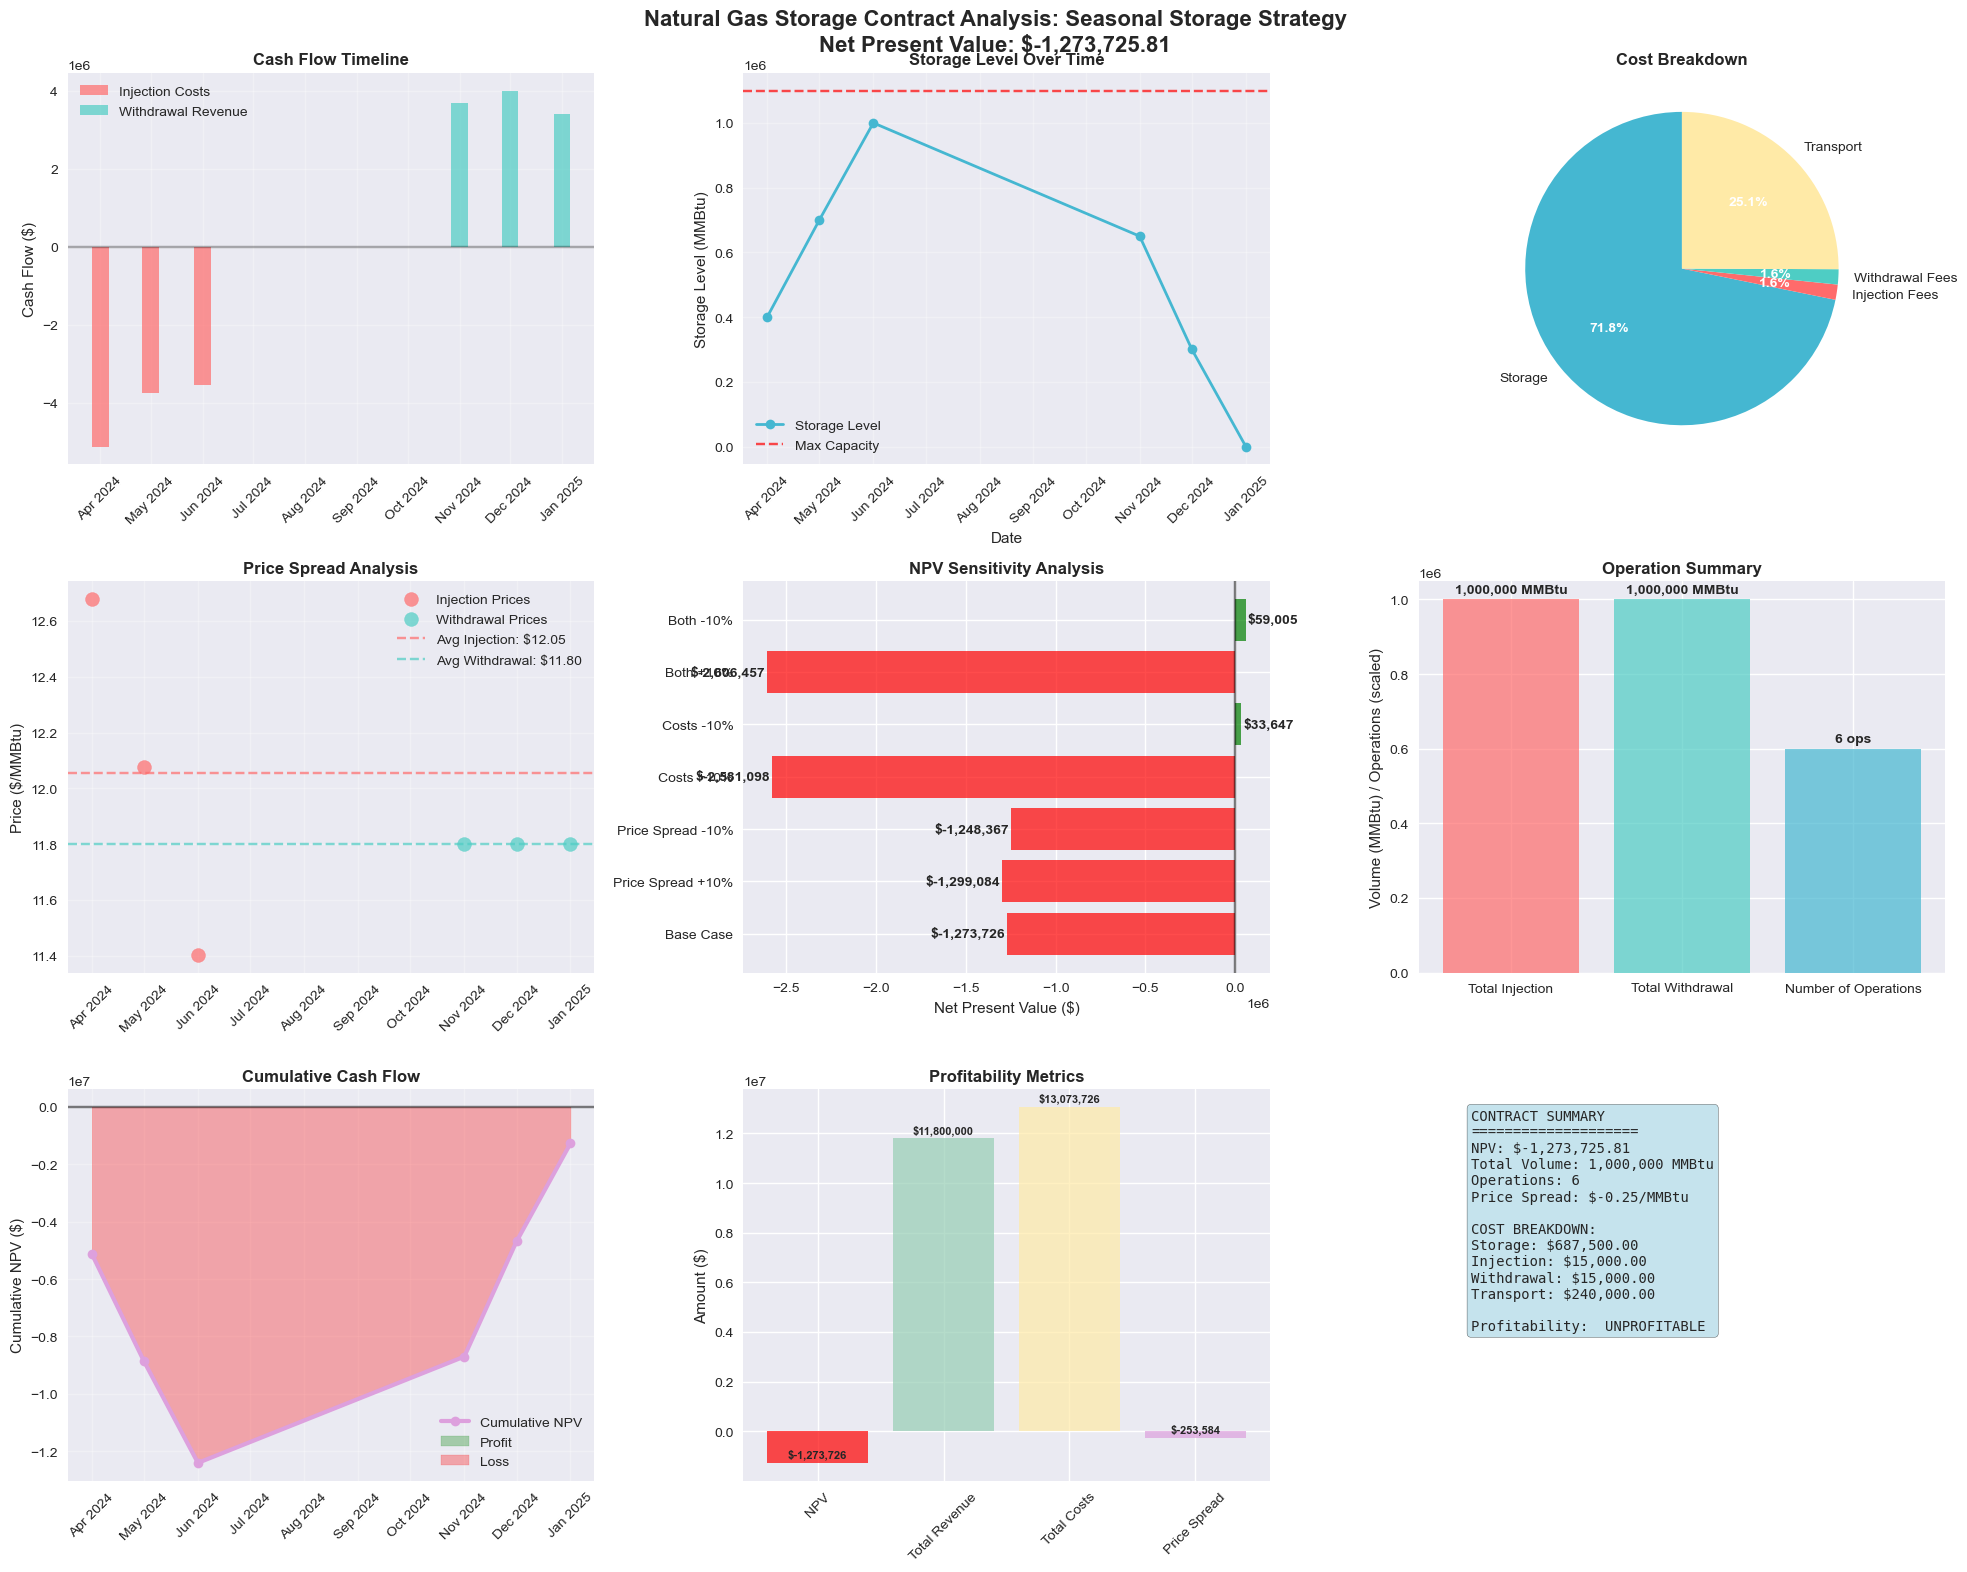

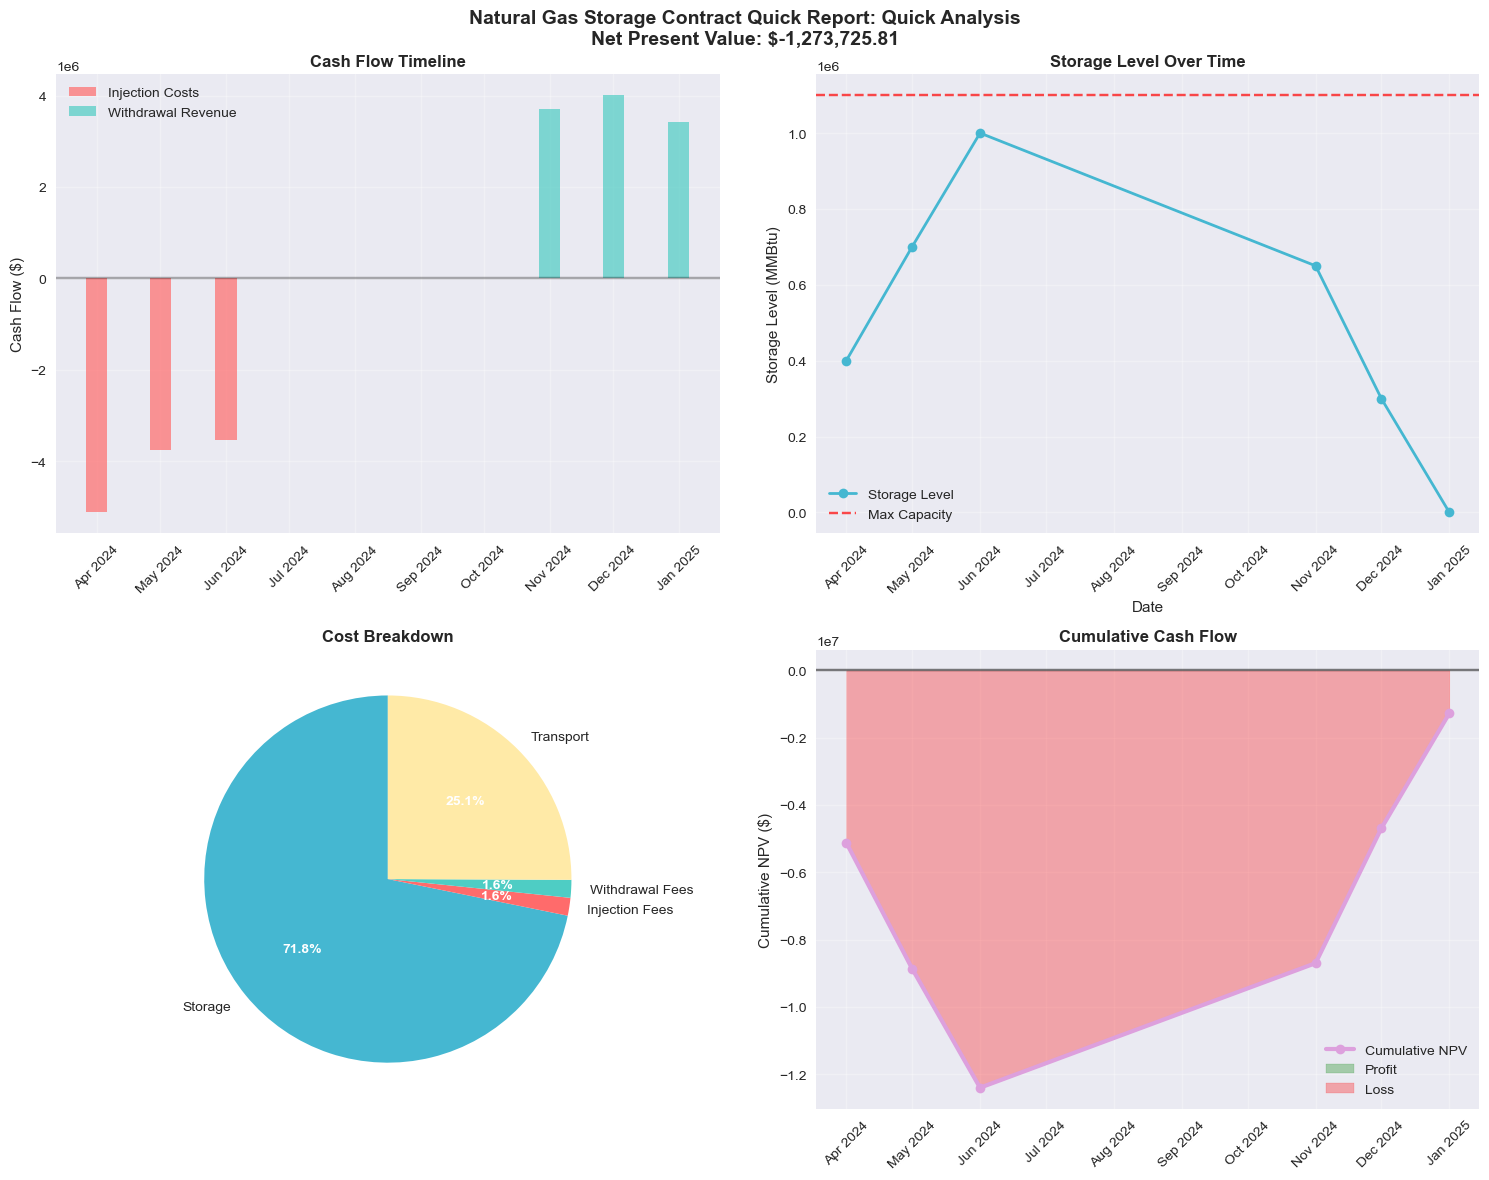


KEY METRICS:
• Total Revenue: $11,800,000.00
• Total Costs: $13,073,725.81
• Price Spread: $-0.25/MMBtu
• Storage Costs: $687,500.00
• Number of Operations: 6


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates

class StorageContractVisualizer:
    """Visualization tools for natural gas storage contract analysis"""
    
    def __init__(self, valuation_model):
        self.model = valuation_model
        plt.style.use('seaborn-v0_8')
        self.colors = {
            'injection': '#FF6B6B',
            'withdrawal': '#4ECDC4',
            'storage': '#45B7D1',
            'revenue': '#96CEB4',
            'costs': '#FFEAA7',
            'profit': '#DDA0DD'
        }
    
    def create_comprehensive_dashboard(self, valuation_result, contract_name="Storage Contract"):
        """Create a comprehensive dashboard with multiple visualizations"""
        if not valuation_result['success']:
            print(f"Cannot create dashboard: {valuation_result['error']}")
            return
        
        fig = plt.figure(figsize=(20, 16))
        
        # Create subplot grid
        gs = fig.add_gridspec(3, 3)
        
        # 1. Cash Flow Timeline
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_cash_flow_timeline(ax1, valuation_result)
        
        # 2. Storage Level Over Time
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_storage_levels(ax2, valuation_result)
        
        # 3. Cost Breakdown
        ax3 = fig.add_subplot(gs[0, 2])
        self._plot_cost_breakdown(ax3, valuation_result)
        
        # 4. Price Spread Analysis
        ax4 = fig.add_subplot(gs[1, 0])
        self._plot_price_spread(ax4, valuation_result)
        
        # 5. NPV Sensitivity Analysis
        ax5 = fig.add_subplot(gs[1, 1])
        self._plot_sensitivity_analysis(ax5, valuation_result)
        
        # 6. Operation Summary
        ax6 = fig.add_subplot(gs[1, 2])
        self._plot_operation_summary(ax6, valuation_result)
        
        # 7. Cumulative Cash Flow
        ax7 = fig.add_subplot(gs[2, 0])
        self._plot_cumulative_cash_flow(ax7, valuation_result)
        
        # 8. Profitability Metrics
        ax8 = fig.add_subplot(gs[2, 1])
        self._plot_profitability_metrics(ax8, valuation_result)
        
        # 9. Contract Summary
        ax9 = fig.add_subplot(gs[2, 2])
        self._plot_contract_summary(ax9, valuation_result)
        
        plt.suptitle(f'Natural Gas Storage Contract Analysis: {contract_name}\n'
                    f'Net Present Value: ${valuation_result["net_present_value"]:,.2f}', 
                    fontsize=16, fontweight='bold', y=0.98)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_cash_flow_timeline(self, ax, result):
        """Plot cash flow timeline by operation"""
        cash_flows = result['cash_flow_details']
        
        # Separate injection and withdrawal operations
        injections = cash_flows[cash_flows['operation_type'] == 'injection']
        withdrawals = cash_flows[cash_flows['operation_type'] == 'withdrawal']
        
        # Plot injection costs (negative cash flow)
        ax.bar(injections['date'], -injections['total_cost'], 
               color=self.colors['injection'], alpha=0.7, label='Injection Costs', width=10)
        
        # Plot withdrawal revenues (positive cash flow)
        ax.bar(withdrawals['date'], withdrawals['net_cash_flow'], 
               color=self.colors['withdrawal'], alpha=0.7, label='Withdrawal Revenue', width=10)
        
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax.set_title('Cash Flow Timeline', fontweight='bold')
        ax.set_ylabel('Cash Flow ($)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    def _plot_storage_levels(self, ax, result):
        """Plot storage levels over time"""
        cash_flows = result['cash_flow_details']
        
        ax.plot(cash_flows['date'], cash_flows['storage_level_after'], 
                marker='o', linewidth=2, color=self.colors['storage'], label='Storage Level')
        
        # Add capacity line
        max_capacity = cash_flows['storage_level_after'].max() * 1.1
        ax.axhline(y=max_capacity, color='red', linestyle='--', alpha=0.7, label='Max Capacity')
        
        ax.set_title('Storage Level Over Time', fontweight='bold')
        ax.set_ylabel('Storage Level (MMBtu)')
        ax.set_xlabel('Date')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    def _plot_cost_breakdown(self, ax, result):
        """Plot pie chart of cost breakdown"""
        costs = {
            'Storage': result['storage_costs'],
            'Injection Fees': result['injection_costs'],
            'Withdrawal Fees': result['withdrawal_costs'],
            'Transport': result['transport_costs']
        }
        
        # Filter out zero costs
        costs = {k: v for k, v in costs.items() if v > 0}
        
        if costs:
            colors = [self.colors['storage'], self.colors['injection'], 
                     self.colors['withdrawal'], self.colors['costs']]
            wedges, texts, autotexts = ax.pie(costs.values(), labels=costs.keys(), 
                                             autopct='%1.1f%%', colors=colors[:len(costs)],
                                             startangle=90)
            
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
            
            ax.set_title('Cost Breakdown', fontweight='bold')
    
    def _plot_price_spread(self, ax, result):
        """Plot injection vs withdrawal prices"""
        cash_flows = result['cash_flow_details']
        operations = result['operations_summary']
        
        # Create price comparison
        injection_dates = cash_flows[cash_flows['operation_type'] == 'injection']['date']
        injection_prices = cash_flows[cash_flows['operation_type'] == 'injection']['price']
        withdrawal_dates = cash_flows[cash_flows['operation_type'] == 'withdrawal']['date']
        withdrawal_prices = cash_flows[cash_flows['operation_type'] == 'withdrawal']['price']
        
        ax.scatter(injection_dates, injection_prices, color=self.colors['injection'], 
                  s=100, label='Injection Prices', alpha=0.7)
        ax.scatter(withdrawal_dates, withdrawal_prices, color=self.colors['withdrawal'], 
                  s=100, label='Withdrawal Prices', alpha=0.7)
        
        # Add average price lines
        ax.axhline(y=operations['average_injection_price'], color=self.colors['injection'], 
                  linestyle='--', alpha=0.7, label=f"Avg Injection: ${operations['average_injection_price']:.2f}")
        ax.axhline(y=operations['average_withdrawal_price'], color=self.colors['withdrawal'], 
                  linestyle='--', alpha=0.7, label=f"Avg Withdrawal: ${operations['average_withdrawal_price']:.2f}")
        
        ax.set_title('Price Spread Analysis', fontweight='bold')
        ax.set_ylabel('Price ($/MMBtu)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    def _plot_sensitivity_analysis(self, ax, result):
        """Plot NPV sensitivity to key parameters"""
        base_npv = result['net_present_value']
        price_spread = result['operations_summary']['price_spread']
        total_costs = result['total_costs']
        
        # Sensitivity scenarios
        scenarios = ['Base Case', 'Price Spread +10%', 'Price Spread -10%', 
                    'Costs +10%', 'Costs -10%', 'Both +10%', 'Both -10%']
        
        npv_scenarios = [
            base_npv,
            base_npv + (price_spread * result['operations_summary']['total_withdrawal_volume'] * 0.1),
            base_npv - (price_spread * result['operations_summary']['total_withdrawal_volume'] * 0.1),
            base_npv - total_costs * 0.1,
            base_npv + total_costs * 0.1,
            base_npv + (price_spread * result['operations_summary']['total_withdrawal_volume'] * 0.1) - total_costs * 0.1,
            base_npv - (price_spread * result['operations_summary']['total_withdrawal_volume'] * 0.1) + total_costs * 0.1
        ]
        
        colors = ['green' if x >= 0 else 'red' for x in npv_scenarios]
        bars = ax.barh(scenarios, npv_scenarios, color=colors, alpha=0.7)
        
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        ax.set_title('NPV Sensitivity Analysis', fontweight='bold')
        ax.set_xlabel('Net Present Value ($)')
        
        # Add value labels
        for bar, value in zip(bars, npv_scenarios):
            ax.text(bar.get_width() + (10000 if value >= 0 else -10000), 
                   bar.get_y() + bar.get_height()/2, 
                   f'${value:,.0f}', ha='left' if value >= 0 else 'right', 
                   va='center', fontweight='bold')
    
    def _plot_operation_summary(self, ax, result):
        """Plot operation volume summary"""
        operations = result['operations_summary']
        
        categories = ['Total Injection', 'Total Withdrawal', 'Number of Operations']
        values = [
            operations['total_injection_volume'],
            operations['total_withdrawal_volume'], 
            operations['number_of_operations'] * 100000  # Scale for visibility
        ]
        
        colors = [self.colors['injection'], self.colors['withdrawal'], self.colors['storage']]
        bars = ax.bar(categories, values, color=colors, alpha=0.7)
        
        ax.set_title('Operation Summary', fontweight='bold')
        ax.set_ylabel('Volume (MMBtu) / Operations (scaled)')
        
        # Add value labels
        for bar, value, category in zip(bars, values, categories):
            if category == 'Number of Operations':
                label = f'{operations["number_of_operations"]} ops'
            else:
                label = f'{value:,.0f} MMBtu'
            
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10000, 
                   label, ha='center', va='bottom', fontweight='bold')
    
    def _plot_cumulative_cash_flow(self, ax, result):
        """Plot cumulative cash flow over time"""
        cash_flows = result['cash_flow_details'].copy()
        cash_flows = cash_flows.sort_values('date')
        cash_flows['cumulative_cash_flow'] = cash_flows['net_cash_flow'].cumsum()
        
        ax.plot(cash_flows['date'], cash_flows['cumulative_cash_flow'], 
                marker='o', linewidth=3, color=self.colors['profit'], label='Cumulative NPV')
        
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax.fill_between(cash_flows['date'], cash_flows['cumulative_cash_flow'], 
                       where=(cash_flows['cumulative_cash_flow'] >= 0), 
                       color='green', alpha=0.3, label='Profit')
        ax.fill_between(cash_flows['date'], cash_flows['cumulative_cash_flow'], 
                       where=(cash_flows['cumulative_cash_flow'] < 0), 
                       color='red', alpha=0.3, label='Loss')
        
        ax.set_title('Cumulative Cash Flow', fontweight='bold')
        ax.set_ylabel('Cumulative NPV ($)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    def _plot_profitability_metrics(self, ax, result):
        """Plot key profitability metrics"""
        metrics = {
            'NPV': result['net_present_value'],
            'Total Revenue': result['total_revenue'],
            'Total Costs': result['total_costs'],
            'Price Spread': result['operations_summary']['price_spread'] * result['operations_summary']['total_withdrawal_volume']
        }
        
        colors = ['green' if metrics['NPV'] >= 0 else 'red', 
                 self.colors['revenue'], self.colors['costs'], self.colors['profit']]
        
        bars = ax.bar(metrics.keys(), metrics.values(), color=colors, alpha=0.7)
        
        ax.set_title('Profitability Metrics', fontweight='bold')
        ax.set_ylabel('Amount ($)')
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        # Add value labels
        for bar, value in zip(bars, metrics.values()):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(metrics.values())*0.01, 
                   f'${value:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    
    def _plot_contract_summary(self, ax, result):
        """Create a text summary of the contract"""
        ax.axis('off')
        
        summary_text = [
            "CONTRACT SUMMARY",
            "=" * 20,
            f"NPV: ${result['net_present_value']:,.2f}",
            f"Total Volume: {result['operations_summary']['total_injection_volume']:,.0f} MMBtu",
            f"Operations: {result['operations_summary']['number_of_operations']}",
            f"Price Spread: ${result['operations_summary']['price_spread']:.2f}/MMBtu",
            "",
            "COST BREAKDOWN:",
            f"Storage: ${result['storage_costs']:,.2f}",
            f"Injection: ${result['injection_costs']:,.2f}",
            f"Withdrawal: ${result['withdrawal_costs']:,.2f}",
            f"Transport: ${result['transport_costs']:,.2f}",
            "",
            f"Profitability: {' PROFITABLE' if result['net_present_value'] > 0 else ' UNPROFITABLE'}"
        ]
        
        ax.text(0.1, 0.95, '\n'.join(summary_text), transform=ax.transAxes,
               fontfamily='monospace', verticalalignment='top', fontsize=10,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

    def create_simple_report(self, valuation_result, contract_name="Storage Contract"):
        """Create a simple one-page report for quick analysis"""
        if not valuation_result['success']:
            print(f"Cannot create report: {valuation_result['error']}")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        self._plot_cash_flow_timeline(ax1, valuation_result)
        self._plot_storage_levels(ax2, valuation_result)
        self._plot_cost_breakdown(ax3, valuation_result)
        self._plot_cumulative_cash_flow(ax4, valuation_result)
        
        plt.suptitle(f'Natural Gas Storage Contract Quick Report: {contract_name}\n'
                    f'Net Present Value: ${valuation_result["net_present_value"]:,.2f}', 
                    fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

# Enhanced test function with visualization
def test_with_visualization():
    """Test the valuation model with comprehensive visualization"""
    
    # Create sample price data
    def create_sample_price_data():
        dates = pd.date_range('2020-10-31', '2024-09-30', freq='ME')
        prices = [10.1, 10.3, 11.0, 10.9, 10.9, 10.9, 10.4, 9.84, 10.0, 10.1, 10.3, 10.2,
                  10.1, 11.2, 11.4, 11.5, 11.8, 11.5, 10.7, 10.7, 10.4, 10.5, 10.4, 10.8,
                  11.0, 11.6, 11.6, 12.1, 11.7, 12.0, 11.5, 11.2, 10.9, 11.4, 11.1, 11.5,
                  11.8, 12.2, 12.8, 12.6, 12.4, 12.7, 12.1, 11.4, 11.5, 11.6, 11.5, 11.8]
        return pd.DataFrame({'date': dates, 'price': prices})
    
    price_data = create_sample_price_data()
    model = NaturalGasStorageValuation(price_data)
    
    # Test a profitable contract
    print(" Testing Storage Contract with Visualization")
    print("=" * 60)
    
    result = model.calculate_contract_value(
        injection_dates=[
            datetime(2024, 4, 1), 
            datetime(2024, 5, 1), 
            datetime(2024, 6, 1)
        ],
        withdrawal_dates=[
            datetime(2024, 11, 1), 
            datetime(2024, 12, 1), 
            datetime(2025, 1, 1)
        ],
        injection_volumes=[400000, 300000, 300000],
        withdrawal_volumes=[350000, 350000, 300000],
        injection_rate=500000,
        withdrawal_rate=500000,
        max_storage_capacity=1500000,
        storage_cost_per_day=2500,
        injection_fee_per_mmbtu=0.015,
        withdrawal_fee_per_mmbtu=0.015,
        transport_cost_per_trip=40000
    )
    
    if result['success']:
        print(f" Contract Analysis Complete!")
        print(f" Net Present Value: ${result['net_present_value']:,.2f}")
        print(f" Creating visualizations...")
        
        # Create visualizations
        visualizer = StorageContractVisualizer(model)
        
        # Comprehensive dashboard
        visualizer.create_comprehensive_dashboard(result, "Seasonal Storage Strategy")
        
        # Simple report
        visualizer.create_simple_report(result, "Quick Analysis")
        
        # Print key metrics
        print("\n" + "=" * 60)
        print("KEY METRICS:")
        print(f"• Total Revenue: ${result['total_revenue']:,.2f}")
        print(f"• Total Costs: ${result['total_costs']:,.2f}")
        print(f"• Price Spread: ${result['operations_summary']['price_spread']:.2f}/MMBtu")
        print(f"• Storage Costs: ${result['storage_costs']:,.2f}")
        print(f"• Number of Operations: {result['operations_summary']['number_of_operations']}")
        
    else:
        print(f" Analysis failed: {result['error']}")
    
    return result

if __name__ == "__main__":
    # Run the visualization test
    test_result = test_with_visualization()